<IPython.core.display.Javascript object>


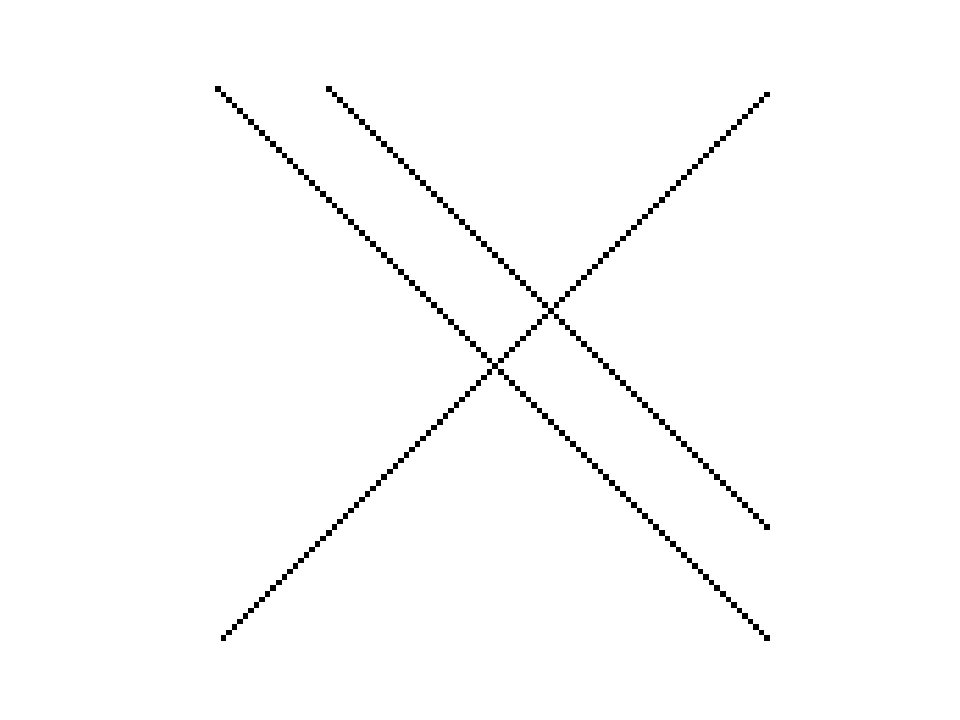

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage import data_dir
from skimage.transform import radon, iradon
from scipy.ndimage import zoom
%matplotlib notebook

num =100
#mat = np.identity(num)
mat = np.zeros((num,num))
#mat = zip(*mat1[::-1])

#mat = np.asarray(mat)

for i in range(0,num, 1): 
    for j in range(0,num, 1):  
        #mat[i,j]=np.random.random()
        if j == i or j==i+20 or j==num-i:
            mat[i,j]= 1

fig, ax = plt.subplots()            
neg=plt.imshow(mat,cmap='Greys' )
ax.set_aspect(1./ax.get_data_ratio())
#fig.colorbar(neg, ax=ax)
ax.axis('off')
fig.savefig('/home/haibin/Desktop/Unit.png')
#plt.show()



In [ ]:
np.min(mat)

In [ ]:
fig, ax = plt.subplots()
projections = radon(mat, theta=[180],circle=False)
#plt.imshow(projections)
plt.plot(projections);
plt.xlabel("Projection axis");
plt.ylabel("Intensity");
plt.show()
#plt.close()

In [ ]:
fig, ax = plt.subplots()
projections = radon(mat,circle=False)
neg=ax.imshow(projections, cmap='coolwarm' )
ax.set_aspect(1./ax.get_data_ratio())
fig.colorbar(neg, ax=ax)
plt.show()

In [ ]:
reconstruction = iradon(projections)

plt.title("Reconstruction\nfrom sinogram")
plt.imshow(reconstruction, cmap=plt.cm.Greys_r)

plt.subplots_adjust(hspace=0.4, wspace=0.5)
plt.show()

In [ ]:
min(mat.shape) 

In [ ]:
import inspect
lines = inspect.getsource(radon)
print lines

In [ ]:
def radon(image, theta=None, circle=None):
    """
    Calculates the radon transform of an image given specified
    projection angles.

    Parameters
    ----------
    image : array_like, dtype=float
        Input image. The rotation axis will be located in the pixel with
        indices ``(image.shape[0] // 2, image.shape[1] // 2)``.
    theta : array_like, dtype=float, optional (default np.arange(180))
        Projection angles (in degrees).
    circle : boolean, optional
        Assume image is zero outside the inscribed circle, making the
        width of each projection (the first dimension of the sinogram)
        equal to ``min(image.shape)``.
        The default behavior (None) is equivalent to False.

    Returns
    -------
    radon_image : ndarray
        Radon transform (sinogram).  The tomography rotation axis will lie
        at the pixel index ``radon_image.shape[0] // 2`` along the 0th
        dimension of ``radon_image``.

    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.
    .. [2] B.R. Ramesh, N. Srinivasa, K. Rajgopal, "An Algorithm for Computing
           the Discrete Radon Transform With Some Applications", Proceedings of
           the Fourth IEEE Region 10 International Conference, TENCON '89, 1989

    Notes
    -----
    Based on code of Justin K. Romberg
    (http://www.clear.rice.edu/elec431/projects96/DSP/bpanalysis.html)

    """
    if image.ndim != 2:
        raise ValueError('The input image must be 2-D')
    if theta is None:
        theta = np.arange(180)
    if circle is None:
        warn('The default of `circle` in `skimage.transform.radon` '
             'will change to `True` in version 0.15.')
        circle = False

    if circle:
        radius = min(image.shape) // 2
        c0, c1 = np.ogrid[0:image.shape[0], 0:image.shape[1]]
        reconstruction_circle = ((c0 - image.shape[0] // 2) ** 2
                                 + (c1 - image.shape[1] // 2) ** 2)
        reconstruction_circle = reconstruction_circle <= radius ** 2
        if not np.all(reconstruction_circle | (image == 0)):
            warn('Radon transform: image must be zero outside the '
                 'reconstruction circle')
        # Crop image to make it square
        slices = []
        for d in (0, 1):
            if image.shape[d] > min(image.shape):
                excess = image.shape[d] - min(image.shape)
                slices.append(slice(int(np.ceil(excess / 2)),
                                    int(np.ceil(excess / 2)
                                        + min(image.shape))))
            else:
                slices.append(slice(None))
        slices = tuple(slices)
        padded_image = image[slices]
    else:
        diagonal = np.sqrt(2) * max(image.shape)
        pad = [int(np.ceil(diagonal - s)) for s in image.shape]
        new_center = [(s + p) // 2 for s, p in zip(image.shape, pad)]
        old_center = [s // 2 for s in image.shape]
        pad_before = [nc - oc for oc, nc in zip(old_center, new_center)]
        pad_width = [(pb, p - pb) for pb, p in zip(pad_before, pad)]
        padded_image = np.pad(image, pad_width, mode='constant',
                              constant_values=0)
    # padded_image is always square
    assert padded_image.shape[0] == padded_image.shape[1]
    radon_image = np.zeros((padded_image.shape[0], len(theta)))
    center = padded_image.shape[0] // 2

    shift0 = np.array([[1, 0, -center],
                       [0, 1, -center],
                       [0, 0, 1]])
    shift1 = np.array([[1, 0, center],
                       [0, 1, center],
                       [0, 0, 1]])

    def build_rotation(theta):
        T = np.deg2rad(theta)
        R = np.array([[np.cos(T), np.sin(T), 0],
                      [-np.sin(T), np.cos(T), 0],
                      [0, 0, 1]])
        return shift1.dot(R).dot(shift0)

    for i in range(len(theta)):
        rotated = _warp_fast(padded_image, build_rotation(theta[i]))
        radon_image[:, i] = rotated.sum(0)
    return radon_image

In [ ]:
image=mat
diagonal = np.sqrt(2) * max(image.shape)
pad = [int(np.ceil(diagonal - s)) for s in image.shape]
new_center = [(s + p) // 2 for s, p in zip(image.shape, pad)]
old_center = [s // 2 for s in image.shape]
pad_before = [nc - oc for oc, nc in zip(old_center, new_center)]
pad_width = [(pb, p - pb) for pb, p in zip(pad_before, pad)]
padded_image = np.pad(image, pad_width, mode='constant',
                      constant_values=0)

In [ ]:
print padded_image.shape
print new_center
print old_center
print pad_before
print pad_width
print padded_image
fig, ax = plt.subplots()
plt.imshow(padded_image)
plt.show()

In [ ]:
image =mat
radius = min(image.shape) // 2
c0, c1 = np.ogrid[0:image.shape[0], 0:image.shape[1]]
reconstruction_circle = ((c0 - image.shape[0] // 2) ** 2
                         + (c1 - image.shape[1] // 2) ** 2)
reconstruction_circle = reconstruction_circle <= radius ** 2
# Crop image to make it square
slices = []
for d in (0, 1):
    if image.shape[d] > min(image.shape):
        excess = image.shape[d] - min(image.shape)
        print "d=",d
        slices.append(slice(int(np.ceil(excess / 2)),
                            int(np.ceil(excess / 2)
                                + min(image.shape))))
    else:
        slices.append(slice(None))
    print slices
slices = tuple(slices)
padded_image = image[slices]


In [ ]:
slice(None)

In [ ]:
print padded_image.shape
fig, ax = plt.subplots()
plt.imshow(padded_image)
plt.show()

In [ ]:
a = [[1, 2], [3, 4]]
np.pad(a, ((3, 2), (1, 1)), 'minimum')